In [1]:
# import libraries
library(tidyverse)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# import data
data = read.csv("diabeticVision.csv")

In [3]:
head(data)

,X,id,laser,eye,age,type,trt,futime,status,risk
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<int>,<int>
1,1,5,argon,left,28,adult,1,46.23,0,9
2,2,5,argon,left,28,adult,0,46.23,0,9
3,3,14,argon,right,12,juvenile,1,42.50,0,8
4,4,14,argon,right,12,juvenile,0,31.30,1,6
5,5,16,xenon,right,9,juvenile,1,42.27,0,11
6,6,16,xenon,right,9,juvenile,0,42.27,0,11


In [4]:
# drop the first column(running number)
data = data[-c(1)]

# EDA

In [5]:
# Check the duplicate id
length(unique(data$id))
length(data$id)

[1] 197

[1] 394

In [6]:
# Summarize data to see how data is distributed
summary(data)

       id            laser               eye                 age       
 Min.   :   5.0   Length:394         Length:394         Min.   : 1.00  
 1st Qu.: 480.0   Class :character   Class :character   1st Qu.:10.00  
 Median : 834.0   Mode  :character   Mode  :character   Median :16.00  
 Mean   : 873.2                                         Mean   :20.78  
 3rd Qu.:1296.0                                         3rd Qu.:30.00  
 Max.   :1749.0                                         Max.   :58.00  
     type                trt          futime          status      
 Length:394         Min.   :0.0   Min.   : 0.30   Min.   :0.0000  
 Class :character   1st Qu.:0.0   1st Qu.:13.98   1st Qu.:0.0000  
 Mode  :character   Median :0.5   Median :38.80   Median :0.0000  
                    Mean   :0.5   Mean   :35.58   Mean   :0.3934  
                    3rd Qu.:1.0   3rd Qu.:54.25   3rd Qu.:1.0000  
                    Max.   :1.0   Max.   :74.97   Max.   :1.0000  
      risk       
 Min.   :

In [7]:
# Percent of each variable
print("laser")
table(data$laser)*100/length(data$id)
print("eye")
table(data$eye)*100/length(data$id)
print("type")
table(data$type)*100/length(data$id)
print("treatment")
table(as.factor(data$trt))*100/length(data$id)

[1] "laser"



   argon    xenon 
49.23858 50.76142 

[1] "eye"



    left    right 
54.82234 45.17766 

[1] "type"



   adult juvenile 
42.13198 57.86802 

[1] "treatment"



 0  1 
50 50 

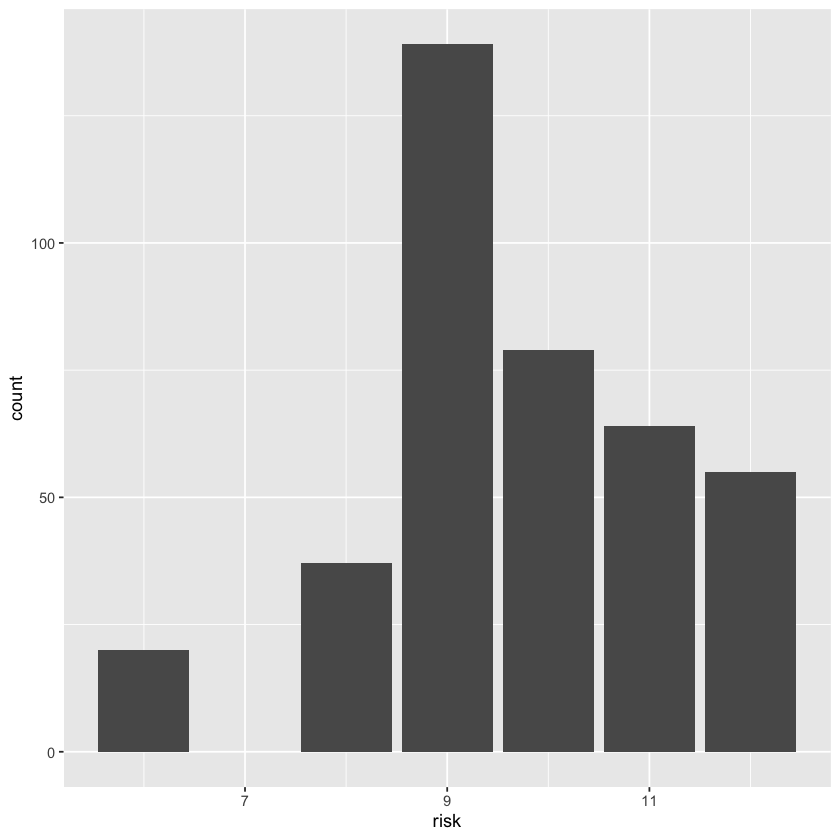

In [8]:
ggplot(data, aes(risk)) +
  geom_bar()

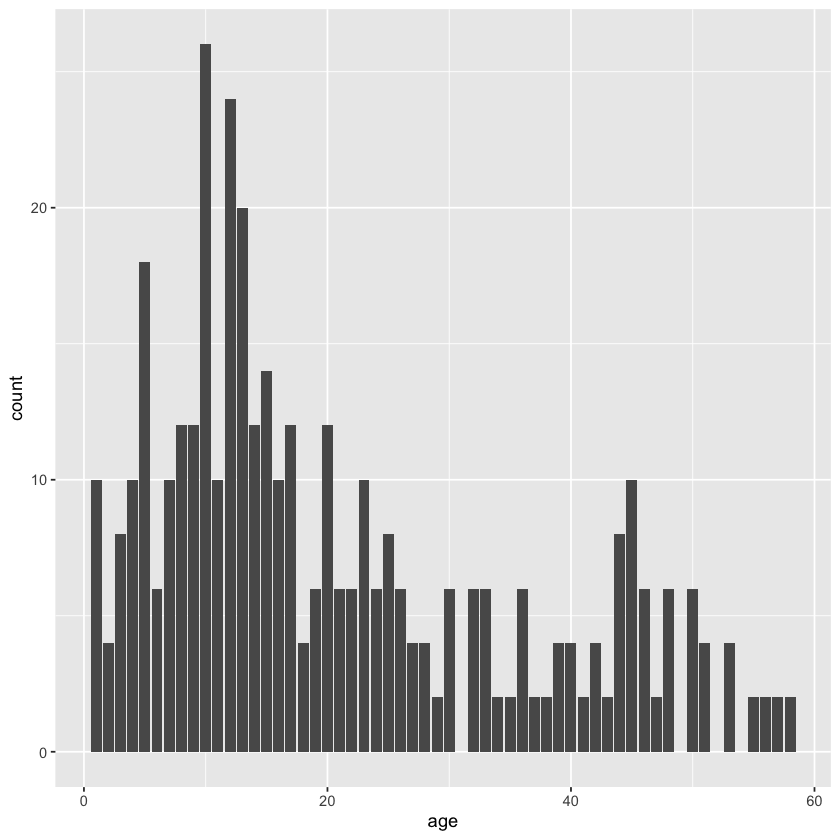

In [9]:
ggplot(data, aes(age)) +
  geom_bar()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


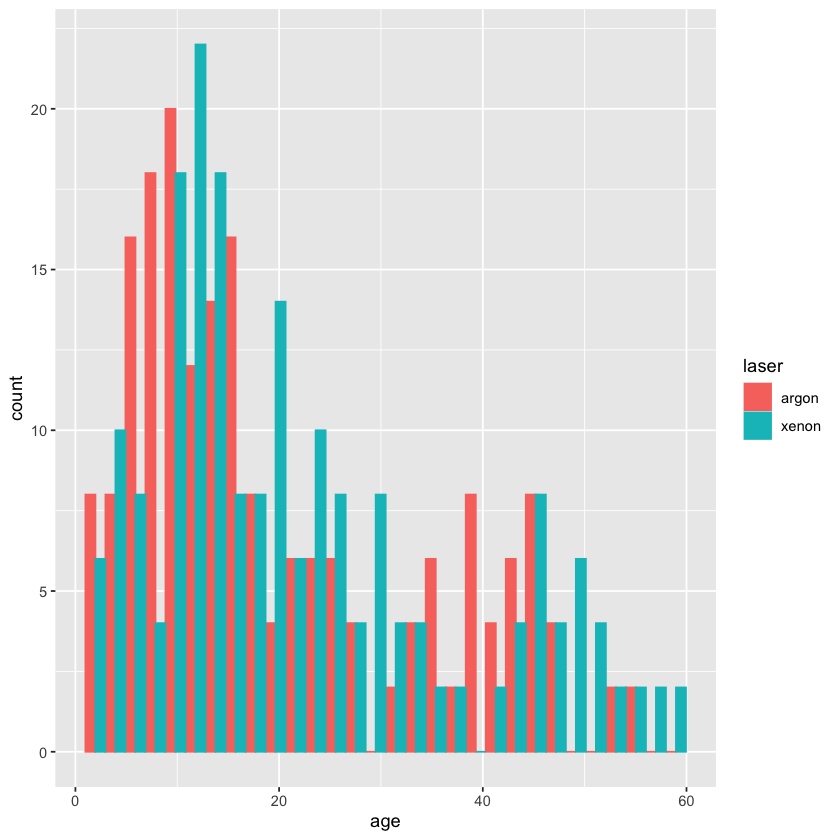

In [10]:
ggplot(data, aes(x=age, color=laser, fill=laser)) +
  geom_histogram(position="dodge")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


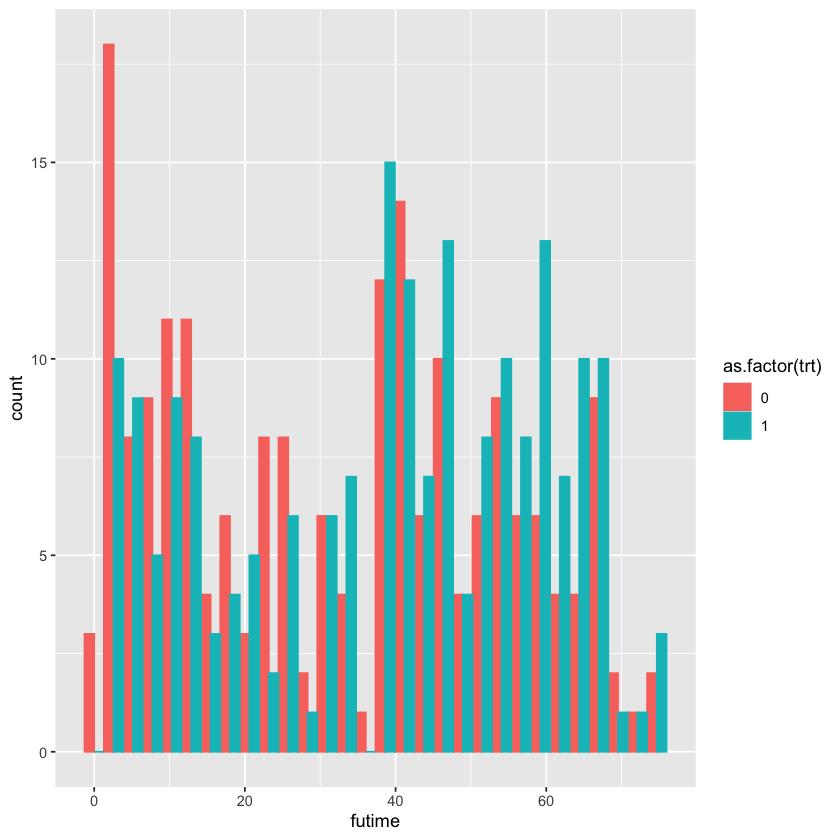

In [11]:
ggplot(data, aes(x=futime, color=as.factor(trt), fill=as.factor(trt))) +
  geom_histogram(position="dodge")

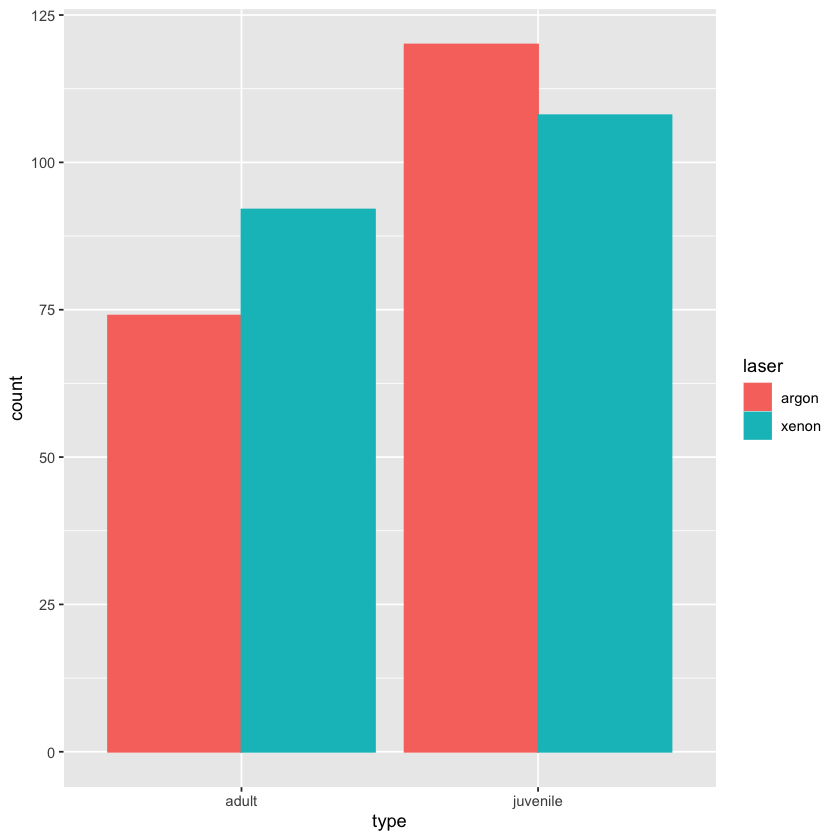

In [12]:
ggplot(data, aes(x=type, color=laser, fill=laser)) +
  geom_bar(position="dodge")

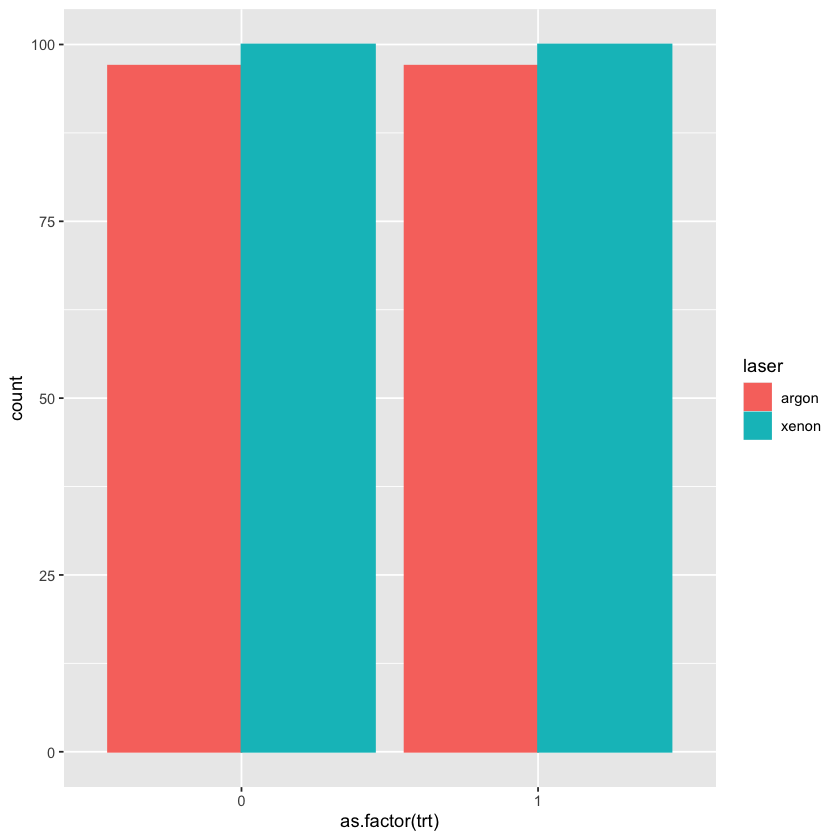

In [13]:
ggplot(data, aes(x=as.factor(trt), color=laser, fill=laser)) +
  geom_bar(position="dodge")

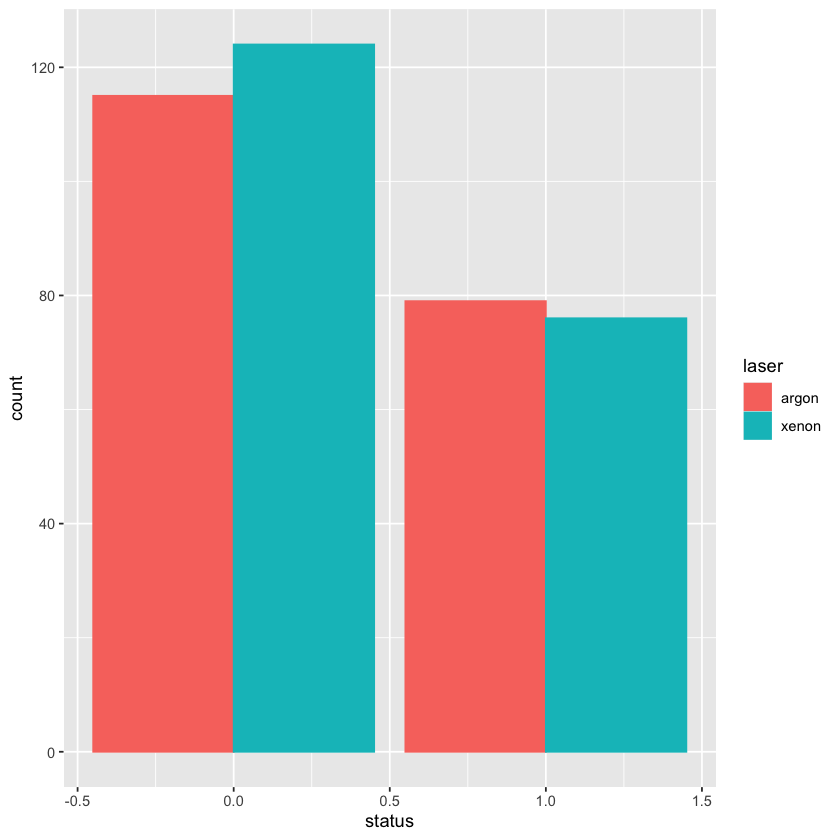

In [14]:
ggplot(data, aes(x=status, color=laser, fill=laser)) +
  geom_bar(position="dodge")

# Model

In [15]:
library(survival)

Interaction between trt and control vs laser types

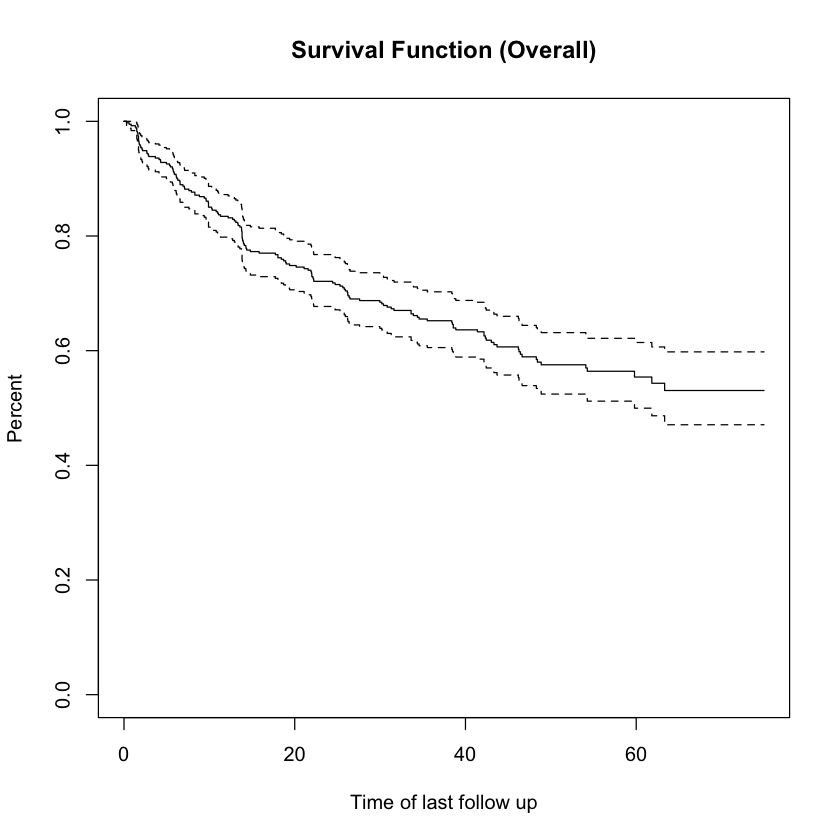

In [17]:
# plot overall survival function
survobj <- with(data, Surv(futime, status))
fit0 <- survfit(survobj~1, data=data)
# summary(fit0)
plot(fit0, xlab="Time of last follow up", 
   ylab="Percent",
   main ="Survival Function (Overall)") 

Kaplan-Meier Curve by type of treatment and study group

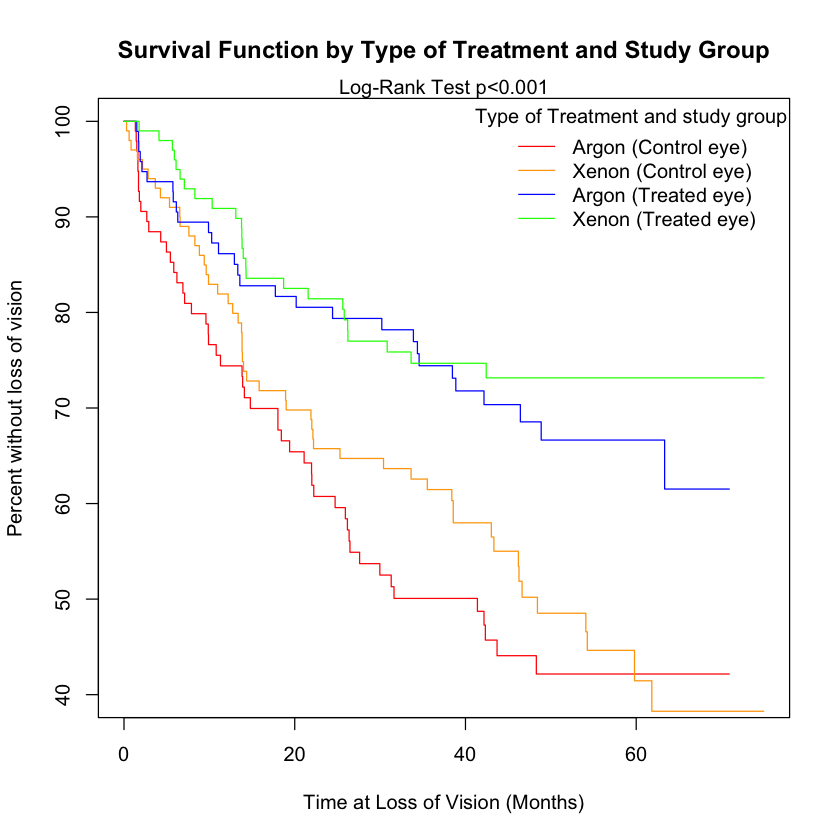

In [18]:
fitc <- survfit(survobj~trt+laser, data=data)
plot(fitc, xlab="Time at Loss of Vision (Months)", 
   ylab="Percent without loss of vision", yscale=100, ylim=c(1, 0.4),
   main="Survival Function by Type of Treatment and Study Group",
   col = c('red', 'orange', 'blue', 'green'))
legend_text = c('Argon (Control eye)', 'Xenon (Control eye)',
                'Argon (Treated eye)', 'Xenon (Treated eye)')
legend('topright', legend=legend_text, 
       title='Type of Treatment and study group', bty='n',
       col=c('red', 'orange', 'blue', 'green'), lty=1)
mtext('Log-Rank Test p<0.001', side = 3)

the survival function of treatment types in the different study groups.
The x-axis shows the time at the loss of vision, while the y-axis shows the percentage of patients
without vision loss.

In [53]:
# Log-rank test for the curve above
survdiff(survobj~trt+laser, data=data)

Call:
survdiff(formula = survobj ~ trt + laser, data = data)

                     N Observed Expected (O-E)^2/E (O-E)^2/V
trt=0, laser=argon  97       50     32.6      9.24     11.74
trt=0, laser=xenon 100       51     39.1      3.60      4.82
trt=1, laser=argon  97       29     40.1      3.09      4.17
trt=1, laser=xenon 100       25     43.1      7.60     10.55

 Chisq= 23.6  on 3 degrees of freedom, p= 3e-05 

The log-rank test shows that at least one curve different from others.

### Perform the Cox proportional hazard model

In [130]:
cox_model = coxph(survobj~ age + risk +
                  laser*as.factor(trt), data=data, cluster = id)
summary(cox_model)

Call:
coxph(formula = survobj ~ age + risk + laser * as.factor(trt), 
    data = data, cluster = id)

  n= 394, number of events= 155 

                                coef exp(coef)  se(coef) robust se      z
age                         0.005334  1.005349  0.005473  0.006100  0.875
risk                        0.146871  1.158204  0.055728  0.058597  2.506
laserxenon                 -0.169242  0.844304  0.199811  0.196118 -0.863
as.factor(trt)1            -0.766822  0.464487  0.234227  0.210918 -3.636
laserxenon:as.factor(trt)1 -0.051551  0.949755  0.338028  0.297940 -0.173
                           Pr(>|z|)    
age                        0.381832    
risk                       0.012195 *  
laserxenon                 0.388159    
as.factor(trt)1            0.000277 ***
laserxenon:as.factor(trt)1 0.862632    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                           exp(coef) exp(-coef) lower .95 upper .95
age                           1.0053     0.9

In [132]:
test.ph <- cox.zph(cox_model)
test.ph

                     chisq df    p
age                  0.355  1 0.55
risk                 1.606  1 0.21
laser                0.663  1 0.42
as.factor(trt)       0.657  1 0.42
laser:as.factor(trt) 0.390  1 0.53
GLOBAL               3.731  5 0.59

Not significant, the model met the proportional hazards assumption.

The treatment types did not affect the visual acuity from the analysis.